In [1]:
%matplotlib inline

from chatty import load_vars
from chatty.analysis.preprocessing import normalize_messages
from chatty.analysis.analysis import sentiment, emoji_table, vocab_table, \
                                     word_count_table
from chatty.sources import imessage_chat
from chatty.visualization import comparison_plot, summary_comparison, \
                                 emoji_comparison, vocab_plot, emoji_plot, \
                                 sentiment_plot, word_count_plot, word_cloud

In [2]:
"""
Replace with an E.164 phone number
or iMessage handle, eg
RECIPIENT_ID = '+13031234567'
RECIPIENT_ID = 'foo@bar.com'

Alternatively, create a file called vars.yml
in the root project directory (adjacent to this notebook)
and define a mapping of the form recipient_id: '+13031234567'.
Doing so will allow you to share your notebook without
revealing the recipient.
"""
RECIPIENT_ID = load_vars()['recipient_id']

In [3]:
assert RECIPIENT_ID != 'CHANGEME'

In [4]:
"""
You can filter messages and pull from sources
other than iMessage by redefining the from_messages
and to_messages variables; subsequent analysis
functions expect that both variables are lists of strings.
"""

from_messages = imessage_chat(RECIPIENT_ID, True)
to_messages = imessage_chat(RECIPIENT_ID, False)

In [5]:
from_normalized = normalize_messages(from_messages)
from_sentiment = sentiment(from_messages)

to_normalized = normalize_messages(to_messages)
to_sentiment = sentiment(to_messages)

In [6]:
summary_comparison(from_normalized, from_sentiment,
                   to_normalized, to_sentiment)

| Metric                                       | From Me   | To Me   |
|----------------------------------------------+-----------+---------|
| Message Count                                | 1,199     | 960     |
| Word Count                                   | 29,686    | 14,243  |
| Avg Message Word Count                       | 24.76     | 14.84   |
| Avg Message Word Count (w/o Stop Words)      | 14.48     | 9.36    |
| Avg Message Character Count                  | 96.38     | 55.48   |
| Avg Message Character Count (w/o Stop Words) | 68.51     | 41.03   |
| Longest Message                              | 208       | 91      |
| Distinct Words                               | 4,345     | 2,631   |
| Distinct Stems                               | 3,438     | 2,229   |
| Distinct English Words                       | 3,773     | 2,248   |
| Distinct Emojis                              | 38        | 32      |
| Emoji Count                                  | 193       | 118     |
| Pct 

In [7]:
# summary_count controls the number of words/emojis
# displayed in a summary
summary_count = 15

from_emojis = emoji_table(from_normalized).head(summary_count)
to_emojis = emoji_table(to_normalized).head(summary_count)
emoji_comparison(from_emojis, to_emojis)

  Emoji Rank  From Me    To Me
------------  ---------  -------
           1  😊         😛
           2  😘         😊
           3  😕         😭
           4  😢         😢
           5  ☺          😘
           6  🤗         😂
           7  🤔         😙
           8  ❤          🤗
           9  😛         😞
          10  🙄         🙄
          11  😚         😉
          12  😂         😚
          13  😈         🤓
          14  😟         😍
          15  😡         ☺


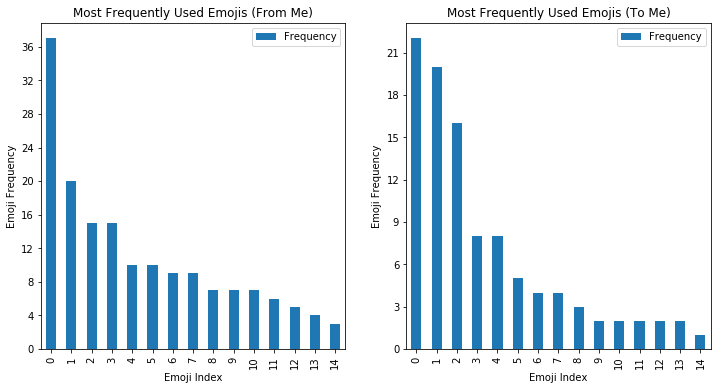

In [8]:
comparison_plot(emoji_plot, from_emojis, to_emojis)

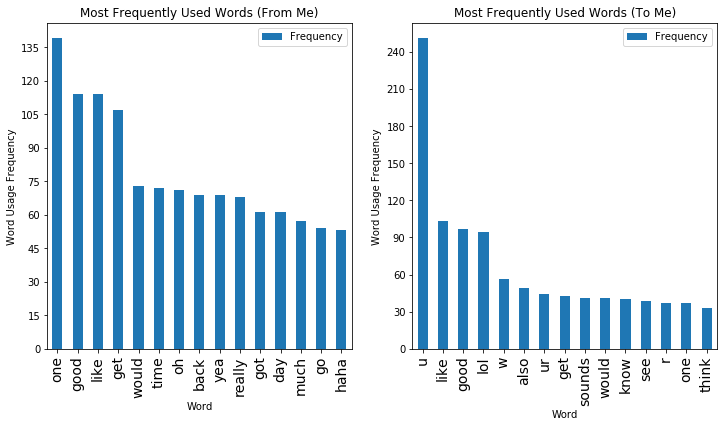

In [9]:
from_vocab = vocab_table(from_normalized).head(summary_count)
to_vocab = vocab_table(to_normalized).head(summary_count)

comparison_plot(vocab_plot, from_vocab, to_vocab)

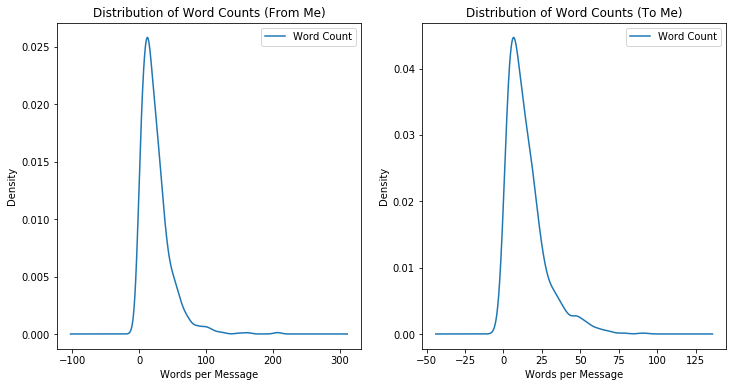

In [10]:
from_wordcounts = word_count_table(from_normalized)
to_wordcounts = word_count_table(to_normalized)

comparison_plot(word_count_plot, from_wordcounts, to_wordcounts)

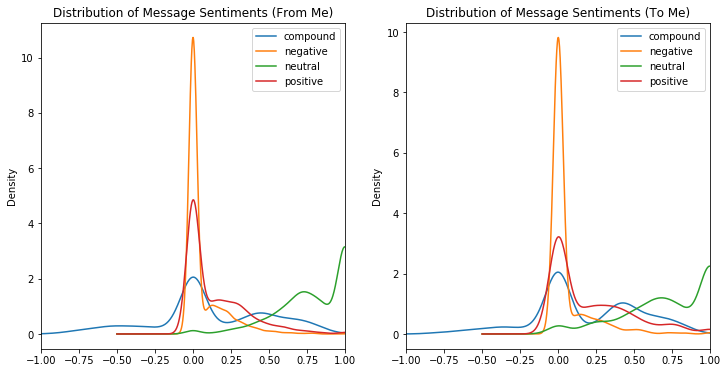

In [11]:
comparison_plot(sentiment_plot, from_sentiment, to_sentiment)

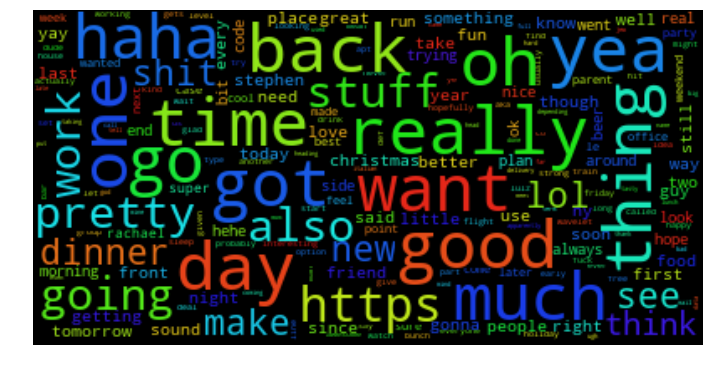

In [12]:
word_cloud(from_normalized)

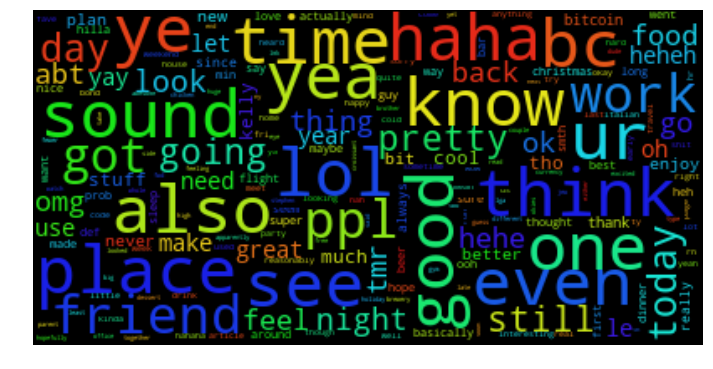

In [13]:
word_cloud(to_normalized)